In [5]:
! jupyter trust food-for-thought-and-ml.ipynb
import sys
# sys.path.append("./recipes/recipes/lib/python3.8/site-packages")
# vscode sometimes gets really annoying not detecting paths. 
site_package_path = glob.glob("/home/*/my_repos/mygithubrepos/vacation-projects/recipes/recipes/lib/python3.8/site-packages")[0]
sys.path.append(site_package_path)
# import plotly.io as pio
# print(pio.renderers)
# pio.renderers.default = "svg"

Signing notebook: food-for-thought-and-ml.ipynb


In [6]:

import pprint
import numpy as np
import pandas as pd
import re
import glob
import pymongo 
import copy
import itertools
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure
import plotly.io as pio
from IPython.display import Image
with open(glob.glob('/home/*/*/*/mymongo')[0]) as f:
    pass_key = f.read()
pass_key=pass_key.strip('\n')

In [7]:

# connect to the database as a user who has read-only privilege. 
user_name = 'ze_readOnly'
client = MongoClient()
try:
    client = MongoClient(username=user_name, password=pass_key)
    print('Server available, you are authenticated as user %s.'%(user_name))

except ConnectionFailure:
    print("Server not available")

Server available, you are authenticated as user ze_readOnly.


In [8]:
db = client.allrecipes
db_collection = db.recipes

In [9]:
# for parsing the collection data
def append_value(dict_obj, key, value):
    [dict_obj[k].append(v) for k,v in zip(key,value)]
# if necessary, vectorize the function for speed 
append_value_v = np.vectorize(append_value)

In [10]:
# append all dicts of recipes from one Author
reciped = {'_id': [], 'title': [], 'Author': [], 'ingredient': [], 'direction': [], 
           'nutrition_per_serving': [], 'total_ratings': [], 
           'ratings': [], 'prep': [], 'cook': [], 'additional': [], 
           'total': [], 'Servings': [], 'Yield': []
          }

keys = list(reciped.keys())
for recipe in db_collection.find(): #({"Author": 'MakeItHealthy'}):
    if recipe.get('nutrition_per_serving'):  # <<--- this is because there are recipes (43 currently) that have no nutirtion info 
       values = [recipe.get(k) for k in keys]
       append_value(reciped,keys,values)

In [11]:
# create a pandas data frame
allkeys = list(reciped.keys())
df = pd.DataFrame([reciped[k] for k in keys]).T
df.columns = allkeys
df.head()

_id                                             title  \
0  611c22af28708657c245a2cb                                Local Kine Wontons   
1  611c22b128708657c245a2cc                            VELVEETA® Potato Bites   
2  611c22b528708657c245a2cd                 Vegan Homemade Plain Cream Cheese   
3  611c22b928708657c245a2ce  Rhode Island-Style Pizza Strips aka Bakery Pizza   
4  611c22be28708657c245a2cf                 Dad's Double Whole Grain Pancakes   

            Author                                         ingredient  \
0             Gina  [1 quart oil for deep frying , 2 (8 ounce) pac...   
1  VELVEETA Cheese  [2 pounds baking potatoes, peeled, cut into ch...   
2             Fioa  [2 cups unsalted raw cashews , ½ teaspoon Hima...   
3       Rebecca C.  [2 pounds prepared pizza dough , 1 (28 ounce) ...   
4            Annie  [1 cup all-purpose flour , 1 ⅓ cups dry milk p...   

                                           direction  \
0  [[Step 1, Heat oil in a large, heavy saucepan ...   
1  [[Step 1, Cook potatoes in boiling water in la...   
2  [[Step 1, Soak cashews in a bowl of water, 8 h...   
3  [[Step 1, Preheat oven to 400 degrees F (200 d...   
4  [[Step 1, In a large bowl, sift all-purpose fl...   

                               nutrition_per_serving  total_ratings  \
0  [168 calories; protein 4.7g; carbohydrates 18g...   [95 Ratings]   
1  [67 calories; protein 2.6g; carbohydrates 11g;...    [3 Ratings]   
2  [48 calories; protein 1.5g; carbohydrates 2.7g...    [1 Ratings]   
3  [275 calories; protein 7.9g; carbohydrates 33g...   [14 Ratings]   
4  [121 calories; protein 4.2g; carbohydrates 17....  [112 Ratings]   

                                      ratings      prep      cook additional  \
0  {'5': 71, '4': 18, '3': 6, '2': 0, '1': 0}  30 mins   20 mins        None   
1    {'5': 1, '4': 0, '3': 0, '2': 1, '1': 1}  20 mins       None   46 mins    
2    {'5': 1, '4': 0, '3': 0, '2': 0, '1': 0}  10 mins       None     9 hrs    
3   {'5': 10, '4': 1, '3': 1, '2': 1, '1': 1}  15 mins   15 mins    30 mins    
4  {'5': 87, '4': 16, '3': 8, '2': 1, '1': 0}  15 mins   20 mins        None   

            total Servings         Yield  
0        50 mins       30   30 servings   
1    1 hr 6 mins       24   24 servings   
2  9 hrs 10 mins       32        2 cups   
3           1 hr       16   16 servings   
4        35 mins       28   28 pancakes

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5085 entries, 0 to 5084
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   _id                    5085 non-null   object
 1   title                  5085 non-null   object
 2   Author                 5084 non-null   object
 3   ingredient             5085 non-null   object
 4   direction              5085 non-null   object
 5   nutrition_per_serving  5085 non-null   object
 6   total_ratings          5085 non-null   object
 7   ratings                5085 non-null   object
 8   prep                   4882 non-null   object
 9   cook                   2753 non-null   object
 10  additional             1522 non-null   object
 11  total                  4902 non-null   object
 12  Servings               5085 non-null   object
 13  Yield                  5085 non-null   object
dtypes: object(14)
memory usage: 556.3+ KB


In [13]:
# working on a copy is always safer with mutable data sturcutres  like pandas data frames
dff = copy.deepcopy(df)

In [14]:
# print out cooking directions for the first couple of them
for ttl, dr in zip(dff.loc[0:1,'title'], dff.loc[0:1,'direction']):
    direction = list(itertools.chain(*dr))
    ds = [d for d in direction  if d != None ]
    print('\x1b[1;31m'+ttl+'\x1b[0m')
    print("\n".join(ds[:-1]))

Local Kine Wontons
Step 1
Heat oil in a large, heavy saucepan to 375 degrees F (190 degrees C).
Step 2
In a medium bowl, mix the cream cheese, soy sauce, imitation crabmeat, water chestnuts and green onions.
Step 3
Place approximately 1 teaspoon of the cream cheese mixture in the center of each wonton wrapper. Fold into triangles and seal edges with moistened fingers.
Step 4
In small batches, fry the wontons in the hot oil 3 to 4 minutes, until golden brown. Drain on paper towels.
VELVEETA® Potato Bites
Step 1
Cook potatoes in boiling water in large saucepan 15 to 20 min. or until tender; drain. Cool 10 min. Mash potatoes until smooth. Add onions, egg and pepper; mix just until blended.
Step 2
Heat oven to 400 degrees F. Empty coating mix into pie plate. Roll potato mixture into 24 balls, using about 2 Tbsp. for each. Insert 1 VELVEETA cube into center of each ball, completely enclosing VELVEETA. Add, 1 at a time, to coating mix; turn to evenly coat. Place on rimmed baking sheet spraye

In [15]:
def fun_int(nut):
    # takes a list, nut
    # extracts the numeric parts of nut units
    # returns  nut values and units
    nut_names = [name for name in nut[::2]]
    values = []
    units = []
    for n in nut:
        try:
            value = '.'.join(re.findall(r'\d+',n))
            values.append(float(value))

            if isinstance (float(value), float):
                unit = n.strip(value)
                units.append(unit)
        except ValueError:
            pass
        
    return nut_names, values, units 

In [16]:
# As noted above some columns are made of lists. Need the  nutrition_per_serving in particular and going to flesh the data out from inside the lists

nut_list = list(itertools.chain(*dff['nutrition_per_serving'])) # gets a list out of data frame

# creating dictionaries 
Nut_names = []
Values = []
Units = []
ObjId = []
    
for nuts,objid in zip(nut_list,dff['_id']):

    nut = nuts.replace(';','')
    nut = nut.split(' ')
    nut[0], nut[1] = nut[1], nut[0]

    nut_names,values,units = fun_int(nut)
    Nut_names.append(nut_names)
    Values.append(values)
    Units.append(units)
    ObjId.append([str(objid)]*len(nut_names))


In [17]:
# creating a dataframe of just nutirents ( call it dnut)
# The gola is to create a multiindex data frame with food id as top level, and nutrient names under it.
# Obviously there are more nutiernts in each recipe than I scraped, but it is ok for now to work with what we have 
list(itertools.chain(*Nut_names))
list(itertools.chain(*Values))
list(itertools.chain(*Units))

arrays = [ np.array(list(itertools.chain(*ObjId))),
          np.array(list(itertools.chain(*Nut_names)))]
dnut = pd.DataFrame({
                     'nut_value':list(itertools.chain(*Values)), 
                     'nut_unit': list(itertools.chain(*Units)),
                    },index = arrays)
dnut = dnut.astype({'nut_value': 'float64'}).T
dnut

611c22af28708657c245a2cb                                         \
                          calories protein carbohydrates  fat cholesterol   
nut_value                    168.0     4.7          18.0  8.6        21.0   
nut_unit                                 g             g    g          mg   

                 611c22b128708657c245a2cc                             ...  \
          sodium                 calories protein carbohydrates  fat  ...   
nut_value  348.8                     67.0     2.6          11.0  1.5  ...   
nut_unit      mg                                g             g    g  ...   

          611c6bb628708657c245b6d1                            \
                           protein carbohydrates  fat sodium   
nut_value                      1.5           5.2  3.9   56.8   
nut_unit                         g             g    g     mg   

          611c6bba28708657c245b6d2                                          \
                          calories protein carbohydrates   fat cholesterol   
nut_value                    444.0    42.0          35.7  15.1        58.7   
nut_unit                                 g             g     g          mg   

                   
           sodium  
nut_value  1584.6  
nut_unit       mg  

[2 rows x 29327 columns]

In [18]:
# parameters collected from various sources including USDA, https://www.healthline.com/health/high-cholesterol/rda, and https://www.acefitness.org/education-and-resources/professional/expert-articles/5904/how-to-determine-the-best-macronutrient-ratio-for-your-goals/
CARB = np.array([.45, .65])  # calorie fraction from carbohydrate 
PRO = np.array([.1,.35])    # calorie fraction from protien
FAT = np.array([.2, .35])   # calorie fraction from fat
CHOL = np.array([5.5, 6.5]) # This corresponds to min and max of cholesterol ([11000/2000, 13000/2000])  mg/cal min and max of cholesterol 
SOD = np.array([1, 2])    # min and max of Sodium

# Pretend we are food experts... and rate food. Ignore food that does not have fat, protien,carbs and sodium for simpilfying task
def food_rater(dff):
    df = copy.deepcopy(dff)
    # if 'calories' in df.columns:
    #     tot_cal = df['calories'].values[0]
    #     print(tot_cal)
    # else:
    LIST1 = list(np.sort(['sodium', 'carbohydrates', 'protein', 'fat']))
    LIST2 = list(np.sort(list(set(['fat', 'protein', 'sodium', 'carbohydrates']).intersection(set(df.columns))))) 

    if LIST1 == LIST2:
                                                          
        if 'cholesterol' not in df:
            tot_cal = 4.0*df['carbohydrates'].get('nut_value') +4.0*df['protein'].get('nut_value') + 9.0*df['fat'].get('nut_value') 
            Xcarb = 4.0*df['carbohydrates'].get('nut_value')/tot_cal
            Xpro = 4.0*df['protein'].get('nut_value')/tot_cal
            Xfat = 9.0*df['fat'].get('nut_value')/tot_cal
            Xsod = df['sodium'].get('nut_value')/tot_cal
            Xchol = 'NA'
        else:
            tot_cal = 4.0*df['carbohydrates'].get('nut_value') +4.0*df['protein'].get('nut_value') + 9.0*df['fat'].get('nut_value') +0.009*df['cholesterol'].get('nut_value') 
                    # assuming unit is mg and cholestrol is still fat with 9 cal/gram cal source
            Xcarb = 4.0*df['carbohydrates'].get('nut_value')/tot_cal
            Xpro = 4.0*df['protein'].get('nut_value')/tot_cal
            Xfat = 9.0*df['fat'].get('nut_value')/tot_cal
            Xsod = df['sodium'].get('nut_value')/tot_cal
            Xchol = df['cholesterol'].get('nut_value')/tot_cal

            if Xchol <= CHOL[0]:
                df.loc['nut_value','cholesterol_level'] = 'low'
            elif Xchol >= CHOL[1]:
                df.loc['nut_value','cholesterol_level'] = 'high'
            else:
                df.loc['nut_value','cholesterol_level'] = 'normal'  
    else:
        tot_cal = np.nan 
        Xcarb = 'NA'
        Xpro = 'NA'
        Xfat = 'NA'
        Xsod = 'NA'
        Xchol = 'NA'

        
        
    if Xcarb != 'NA':  

        if Xcarb  <= CARB[0]:
            df.loc['nut_value','carbohydrates_level'] = 'low'
            df.loc['nut_value','carbohydrates_score'] = 1
        elif Xcarb >= CARB[1]:
            df.loc['nut_value','carbohydrates_level'] = 'high'
            df.loc['nut_value','carbohydrates_score'] = 0
        else:
            df.loc['nut_value','carbohydrates_level'] = 'normal' 
            df.loc['nut_value','carbohydrates_score'] = 2
    else:
            df.loc['nut_value','carbohydrates_level'] = np.nan 
            df.loc['nut_value','carbohydrates_score'] = np.nan
    
    if Xpro != 'NA':  

        if Xpro  <= PRO[0]:
            df.loc['nut_value','protien_level'] = 'low'
            df.loc['nut_value','protien_score'] = 1
        elif Xpro >= PRO[1]:
            df.loc['nut_value','protien_level'] = 'high'
            df.loc['nut_value','protien_score'] = 0
        else:
            df.loc['nut_value','protien_level'] = 'normal' 
            df.loc['nut_value','protien_score'] = 2
    else:
            df.loc['nut_value','protien_level'] = np.nan 
            df.loc['nut_value','protien_score'] = np.nan


    if Xfat != 'NA':    
        
        if Xfat  <= FAT[0]:
            df.loc['nut_value','fat_level'] = 'low'
            df.loc['nut_value','fat_score'] = 1
        elif Xfat >= FAT[1]:
            df.loc['nut_value','fat_level'] = 'high'
            df.loc['nut_value','fat_score'] = 0
        else:
            df.loc['nut_value','fat_level'] = 'normal'
            df.loc['nut_value','fat_score'] = 2
    else:
            df.loc['nut_value','fat_level'] = np.nan
            df.loc['nut_value','fat_score'] = np.nan
        
    if Xsod != 'NA':
        if Xsod <= 1: 
            df.loc['nut_value','sodium_level'] = 'good' 
            df.loc['nut_value','sodium_score'] = 2
        elif Xsod >= SOD[0] and Xsod <=SOD[1]:
            df.loc['nut_value','sodium_level'] = 'normal' 
            df.loc['nut_value','sodium_score'] = 1
        else:  
            df.loc['nut_value','sodium_level'] = 'bad' 
            df.loc['nut_value','sodium_score'] = 0
    else:
        df.loc['nut_value','sodium_level'] = np.nan 
        df.loc['nut_value','sodium_score'] = np.nan

    tot_score = df.fillna(0).loc['nut_value',['_score' in col for col in  df.columns]].sum()
    if tot_score in [0,2]:
        df['overall_food_quality'] = 'bad'
    elif tot_score in [3,4]:
        df['overall_food_quality'] = 'good'
    else:
        df['overall_food_quality'] = 'excellent'
    return df


In [19]:
k = 0
for ids in dff['_id'].values:
    try:
        x,y = dnut.get(str(ids)).shape
    except AttributeError:
        k = k+1
print(k)

0


In [20]:
# Now rate food based on nutrient composition. Note that the food id is appended to each food so we can trace back to it later on
# from functools import lru_cache
# @lru_cache(maxsize=32)
def rate_(dff):
    food=pd.DataFrame()
    for ids in dff['_id'].values:
        try:
            tot_cal = food_rater(dnut.get(str(ids)))
            tot_cal['food_id'] = ids
            food = food.append(tot_cal)
        except AttributeError:
            pass
    return food


In [21]:
food = rate_(dff)
food.loc['nut_value'].head()

calories protein carbohydrates   fat cholesterol sodium  \
nut_value    168.0     4.7          18.0   8.6        21.0  348.8   
nut_value     67.0     2.6          11.0   1.5        11.5  245.0   
nut_value     48.0     1.5           2.7   3.8         NaN   37.4   
nut_value    275.0     7.9          33.0  12.4         8.9  722.5   
nut_value    121.0     4.2          17.4   4.2        36.8  208.9   

          cholesterol_level carbohydrates_level  carbohydrates_score  \
nut_value               low                 low                  1.0   
nut_value               low              normal                  2.0   
nut_value               NaN                 low                  1.0   
nut_value               low              normal                  2.0   
nut_value               low              normal                  2.0   

          protien_level  protien_score fat_level  fat_score sodium_level  \
nut_value        normal            2.0      high        0.0          bad   
nut_value        normal            2.0       low        1.0          bad   
nut_value        normal            2.0      high        0.0         good   
nut_value        normal            2.0      high        0.0          bad   
nut_value        normal            2.0    normal        2.0       normal   

           sodium_score overall_food_quality                   food_id  
nut_value           0.0                 good  611c22af28708657c245a2cb  
nut_value           0.0            excellent  611c22b128708657c245a2cc  
nut_value           2.0            excellent  611c22b528708657c245a2cd  
nut_value           0.0                 good  611c22b928708657c245a2ce  
nut_value           1.0            excellent  611c22be28708657c245a2cf

In [22]:
# try to calculate total labour cost assuming a minimium wage (give yourself a higher wage if you are a pro chief ... or whatever)
labour = copy.deepcopy(dff[["prep","cook","additional","total"]])
labour.head()

prep      cook additional           total
0  30 mins   20 mins        None        50 mins 
1  20 mins       None   46 mins     1 hr 6 mins 
2  10 mins       None     9 hrs   9 hrs 10 mins 
3  15 mins   15 mins    30 mins            1 hr 
4  15 mins   20 mins        None        35 mins

In [23]:
# as you can see above we need to clean up and homogenize the time units. We do that below and compute the total labour cost for each food recipe
def homo_time_units(x):
    if x is not None:
        x = x.replace('s','')
        x_list = x.split(' ')

        if 'hr' in x_list and 'min' in x_list:
                y =float(x_list[0]) + float(x_list[2])/60.0 # time in units of hr
        else:        
            if 'min' in x:
                y=float(x.replace('min',''))/60.0 # time in units of hr

            if  'hr' in x:
                y = float(x.replace('hr','')) 

            if  'day' in x:
                y = float(x.replace('day',''))*24 

                
        return  y 

labour['tot_hrs'] = labour['total'].apply(homo_time_units)
labour['tot_labour_cost($)']= labour['tot_hrs'].apply(lambda x: 10*x)
labour['_id'] = dff['_id']
labour.head()


prep      cook additional           total   tot_hrs  \
0  30 mins   20 mins        None        50 mins   0.833333   
1  20 mins       None   46 mins     1 hr 6 mins   1.100000   
2  10 mins       None     9 hrs   9 hrs 10 mins   9.166667   
3  15 mins   15 mins    30 mins            1 hr   1.000000   
4  15 mins   20 mins        None        35 mins   0.583333   

   tot_labour_cost($)                       _id  
0            8.333333  611c22af28708657c245a2cb  
1           11.000000  611c22b128708657c245a2cc  
2           91.666667  611c22b528708657c245a2cd  
3           10.000000  611c22b928708657c245a2ce  
4            5.833333  611c22be28708657c245a2cf

In [24]:
# wish I could do something with the ingredients so that I can estimate the material cost of each recipe. That would be great. Main problem is getting/scraping prices of each ingredients. Tried walmart's page... but they didn't like it. Told to beat it. ( also read their robots.txt file) 
# Anyway, going to look into the data here a bit further...
# print out ingredients for the first couple of recipes
for ttl, ingredients_ in zip(dff.loc[0:1,'title'], dff.loc[0:1,'ingredient']):
    # ingredients_ = list(itertools.chain(*ing))
    ds = ['- ' + d  for d in ingredients_  if d != None ]
    print('\x1b[1;44m'+ 'Ingredients for ' + ttl+'\x1b[0m')
    print("\n".join(ds[:-1]))



Ingredients for Local Kine Wontons
- 1 quart oil for deep frying 
- 2 (8 ounce) packages cream cheese, softened 
- 2 tablespoons soy sauce 
- 1 (12 ounce) package imitation crabmeat, flaked 
- 1 (5 ounce) can water chestnuts, drained and chopped 
- 5 green onions, chopped 
Ingredients for VELVEETA® Potato Bites
- 2 pounds baking potatoes, peeled, cut into chunks 
- 2 green onions, thinly sliced 
- 1 egg, beaten 
- ¼ teaspoon black pepper 
- ¼ pound VELVEETA®, cut into 24 cubes 
- 1 (2.75 ounce) packet SHAKE 'N BAKE Extra Crispy Seasoned Coating Mix 


In [25]:
# Umm...the 20 unicodes at it again. No expert on html ( no expert on anything for that matter - just a dude with too many interestes than he can work on)
# I can do some silly coding to work around them as

stupid_dict={'¼':.250, 
 '½':.500, 
 '¾':.750,
 '⅐':.142,  
'⅑':.111,  
'⅒':.010, 
 '⅓':.333,  
 '⅔':.667, 
 '⅕':.200, 
 '⅖':.400,  
 '⅗':.600,  
 '⅘':.800,  
 '⅙':.167,  
 '⅚':833,  
 '⅛':.125, 
 '⅜':.375,  
 '⅝':.675,  
 '⅞':.875,  
 '⅟':1.00,  
 '↉':0.00} 

for ks in dff.loc[0:10,'ingredient']:

    [print('\t{}\t{}'.format(s,ks)) for s in stupid_dict.keys() if s in  ks[0]]

	½	['½ cup ketchup ', '½ cup mustard ', '2 cups chocolate flavored crispy rice cereal ', '4 skinless, boneless chicken breast halves ']


In [26]:
# categorical dtypes have a lot less memory footprint than Obj dtypes. Could use something like below if ncassary  
# def to_category(df):
#     for f in df.select_dtypes(include = 'O').columns:
#         df[f] = df[f].astype('category',errors='ignore')
#     return df
# dcat = to_category(df)
# dcat.memory_usage(deep=True).sum()


In [27]:
# It's all about ratings, as someone would say. Let's see how each recipe does on a weighted average rating. Use the weight w = [5,4,3,2,1] corresponding to the number of stars and the order they are in the data
# calculate weighted means of star ratings of each recipe
def wtavg_star(r):
    w = np.array([5,4,3,2,1])
    if list(r.values()):
        avg_star = np.sum(list(r.values())*w)/15.0 #np.sum(w)
        return avg_star 
    else: 
        return np.nan
dff['weighted_mean_ratings'] = dff['ratings'].apply(wtavg_star)
dff.head()

_id                                             title  \
0  611c22af28708657c245a2cb                                Local Kine Wontons   
1  611c22b128708657c245a2cc                            VELVEETA® Potato Bites   
2  611c22b528708657c245a2cd                 Vegan Homemade Plain Cream Cheese   
3  611c22b928708657c245a2ce  Rhode Island-Style Pizza Strips aka Bakery Pizza   
4  611c22be28708657c245a2cf                 Dad's Double Whole Grain Pancakes   

            Author                                         ingredient  \
0             Gina  [1 quart oil for deep frying , 2 (8 ounce) pac...   
1  VELVEETA Cheese  [2 pounds baking potatoes, peeled, cut into ch...   
2             Fioa  [2 cups unsalted raw cashews , ½ teaspoon Hima...   
3       Rebecca C.  [2 pounds prepared pizza dough , 1 (28 ounce) ...   
4            Annie  [1 cup all-purpose flour , 1 ⅓ cups dry milk p...   

                                           direction  \
0  [[Step 1, Heat oil in a large, heavy saucepan ...   
1  [[Step 1, Cook potatoes in boiling water in la...   
2  [[Step 1, Soak cashews in a bowl of water, 8 h...   
3  [[Step 1, Preheat oven to 400 degrees F (200 d...   
4  [[Step 1, In a large bowl, sift all-purpose fl...   

                               nutrition_per_serving  total_ratings  \
0  [168 calories; protein 4.7g; carbohydrates 18g...   [95 Ratings]   
1  [67 calories; protein 2.6g; carbohydrates 11g;...    [3 Ratings]   
2  [48 calories; protein 1.5g; carbohydrates 2.7g...    [1 Ratings]   
3  [275 calories; protein 7.9g; carbohydrates 33g...   [14 Ratings]   
4  [121 calories; protein 4.2g; carbohydrates 17....  [112 Ratings]   

                                      ratings      prep      cook additional  \
0  {'5': 71, '4': 18, '3': 6, '2': 0, '1': 0}  30 mins   20 mins        None   
1    {'5': 1, '4': 0, '3': 0, '2': 1, '1': 1}  20 mins       None   46 mins    
2    {'5': 1, '4': 0, '3': 0, '2': 0, '1': 0}  10 mins       None     9 hrs    
3   {'5': 10, '4': 1, '3': 1, '2': 1, '1': 1}  15 mins   15 mins    30 mins    
4  {'5': 87, '4': 16, '3': 8, '2': 1, '1': 0}  15 mins   20 mins        None   

            total Servings         Yield  weighted_mean_ratings  
0        50 mins       30   30 servings               29.666667  
1    1 hr 6 mins       24   24 servings                0.533333  
2  9 hrs 10 mins       32        2 cups                0.333333  
3           1 hr       16   16 servings                4.000000  
4        35 mins       28   28 pancakes               35.000000

<br>Enough with the ratings, now merge all new data columns created</br>
  They are:
 1. "tot_labour_cost($)" from labour df
 2. all columns from food df. For merging to work smoothly, update the column name food_id to simply _id. Ignore nut_unit rows at this point

In [28]:
food.rename(columns={'food_id':'_id'},inplace=True)
food.head()

calories protein carbohydrates  fat cholesterol sodium  \
nut_value    168.0     4.7          18.0  8.6        21.0  348.8   
nut_unit                 g             g    g          mg     mg   
nut_value     67.0     2.6          11.0  1.5        11.5  245.0   
nut_unit                 g             g    g          mg    mg.   
nut_value     48.0     1.5           2.7  3.8         NaN   37.4   

          cholesterol_level carbohydrates_level  carbohydrates_score  \
nut_value               low                 low                  1.0   
nut_unit                NaN                 NaN                  NaN   
nut_value               low              normal                  2.0   
nut_unit                NaN                 NaN                  NaN   
nut_value               NaN                 low                  1.0   

          protien_level  protien_score fat_level  fat_score sodium_level  \
nut_value        normal            2.0      high        0.0          bad   
nut_unit            NaN            NaN       NaN        NaN          NaN   
nut_value        normal            2.0       low        1.0          bad   
nut_unit            NaN            NaN       NaN        NaN          NaN   
nut_value        normal            2.0      high        0.0         good   

           sodium_score overall_food_quality                       _id  
nut_value           0.0                 good  611c22af28708657c245a2cb  
nut_unit            NaN                 good  611c22af28708657c245a2cb  
nut_value           0.0            excellent  611c22b128708657c245a2cc  
nut_unit            NaN            excellent  611c22b128708657c245a2cc  
nut_value           2.0            excellent  611c22b528708657c245a2cd

In [29]:
food_quality = copy.deepcopy(food.loc['nut_value',:].reset_index().drop(columns=['index']))
food_quality.head()

calories protein carbohydrates   fat cholesterol sodium cholesterol_level  \
0    168.0     4.7          18.0   8.6        21.0  348.8               low   
1     67.0     2.6          11.0   1.5        11.5  245.0               low   
2     48.0     1.5           2.7   3.8         NaN   37.4               NaN   
3    275.0     7.9          33.0  12.4         8.9  722.5               low   
4    121.0     4.2          17.4   4.2        36.8  208.9               low   

  carbohydrates_level  carbohydrates_score protien_level  protien_score  \
0                 low                  1.0        normal            2.0   
1              normal                  2.0        normal            2.0   
2                 low                  1.0        normal            2.0   
3              normal                  2.0        normal            2.0   
4              normal                  2.0        normal            2.0   

  fat_level  fat_score sodium_level  sodium_score overall_food_quality  \
0      high        0.0          bad           0.0                 good   
1       low        1.0          bad           0.0            excellent   
2      high        0.0         good           2.0            excellent   
3      high        0.0          bad           0.0                 good   
4    normal        2.0       normal           1.0            excellent   

                        _id  
0  611c22af28708657c245a2cb  
1  611c22b128708657c245a2cc  
2  611c22b528708657c245a2cd  
3  611c22b928708657c245a2ce  
4  611c22be28708657c245a2cf

In [30]:
labour.shape

(5085, 7)

In [31]:
food_quality.shape

(5085, 17)

In [32]:
final_df = copy.deepcopy(dff)
final_df = final_df.merge(food_quality,on='_id').merge(labour[["tot_hrs", "tot_labour_cost($)","_id"]],on='_id')
final_df.head()

_id                                             title  \
0  611c22af28708657c245a2cb                                Local Kine Wontons   
1  611c22b128708657c245a2cc                            VELVEETA® Potato Bites   
2  611c22b528708657c245a2cd                 Vegan Homemade Plain Cream Cheese   
3  611c22b928708657c245a2ce  Rhode Island-Style Pizza Strips aka Bakery Pizza   
4  611c22be28708657c245a2cf                 Dad's Double Whole Grain Pancakes   

            Author                                         ingredient  \
0             Gina  [1 quart oil for deep frying , 2 (8 ounce) pac...   
1  VELVEETA Cheese  [2 pounds baking potatoes, peeled, cut into ch...   
2             Fioa  [2 cups unsalted raw cashews , ½ teaspoon Hima...   
3       Rebecca C.  [2 pounds prepared pizza dough , 1 (28 ounce) ...   
4            Annie  [1 cup all-purpose flour , 1 ⅓ cups dry milk p...   

                                           direction  \
0  [[Step 1, Heat oil in a large, heavy saucepan ...   
1  [[Step 1, Cook potatoes in boiling water in la...   
2  [[Step 1, Soak cashews in a bowl of water, 8 h...   
3  [[Step 1, Preheat oven to 400 degrees F (200 d...   
4  [[Step 1, In a large bowl, sift all-purpose fl...   

                               nutrition_per_serving  total_ratings  \
0  [168 calories; protein 4.7g; carbohydrates 18g...   [95 Ratings]   
1  [67 calories; protein 2.6g; carbohydrates 11g;...    [3 Ratings]   
2  [48 calories; protein 1.5g; carbohydrates 2.7g...    [1 Ratings]   
3  [275 calories; protein 7.9g; carbohydrates 33g...   [14 Ratings]   
4  [121 calories; protein 4.2g; carbohydrates 17....  [112 Ratings]   

                                      ratings      prep      cook  ...  \
0  {'5': 71, '4': 18, '3': 6, '2': 0, '1': 0}  30 mins   20 mins   ...   
1    {'5': 1, '4': 0, '3': 0, '2': 1, '1': 1}  20 mins       None  ...   
2    {'5': 1, '4': 0, '3': 0, '2': 0, '1': 0}  10 mins       None  ...   
3   {'5': 10, '4': 1, '3': 1, '2': 1, '1': 1}  15 mins   15 mins   ...   
4  {'5': 87, '4': 16, '3': 8, '2': 1, '1': 0}  15 mins   20 mins   ...   

  carbohydrates_score protien_level protien_score fat_level  fat_score  \
0                 1.0        normal           2.0      high        0.0   
1                 2.0        normal           2.0       low        1.0   
2                 1.0        normal           2.0      high        0.0   
3                 2.0        normal           2.0      high        0.0   
4                 2.0        normal           2.0    normal        2.0   

  sodium_level sodium_score overall_food_quality   tot_hrs tot_labour_cost($)  
0          bad          0.0                 good  0.833333           8.333333  
1          bad          0.0            excellent  1.100000          11.000000  
2         good          2.0            excellent  9.166667          91.666667  
3          bad          0.0                 good  1.000000          10.000000  
4       normal          1.0            excellent  0.583333           5.833333  

[5 rows x 33 columns]

In [33]:
# Give the final df some ML love, but first... do some EDA
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5085 entries, 0 to 5084
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _id                    5085 non-null   object 
 1   title                  5085 non-null   object 
 2   Author                 5084 non-null   object 
 3   ingredient             5085 non-null   object 
 4   direction              5085 non-null   object 
 5   nutrition_per_serving  5085 non-null   object 
 6   total_ratings          5085 non-null   object 
 7   ratings                5085 non-null   object 
 8   prep                   4882 non-null   object 
 9   cook                   2753 non-null   object 
 10  additional             1522 non-null   object 
 11  total                  4902 non-null   object 
 12  Servings               5085 non-null   object 
 13  Yield                  5085 non-null   object 
 14  weighted_mean_ratings  4871 non-null   float64
 15  calo

In [34]:
# some useful data are still not in useable form for anlysis.  Try this...
list_to_numeric = ['protein','tot_hrs','tot_labour_cost($)','calories', 'protein','carbohydrates', 'fat', 'cholesterol','sodium']
numeric_dict = {key:'float' for key in list_to_numeric}
final_df = final_df.astype(numeric_dict) 
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5085 entries, 0 to 5084
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _id                    5085 non-null   object 
 1   title                  5085 non-null   object 
 2   Author                 5084 non-null   object 
 3   ingredient             5085 non-null   object 
 4   direction              5085 non-null   object 
 5   nutrition_per_serving  5085 non-null   object 
 6   total_ratings          5085 non-null   object 
 7   ratings                5085 non-null   object 
 8   prep                   4882 non-null   object 
 9   cook                   2753 non-null   object 
 10  additional             1522 non-null   object 
 11  total                  4902 non-null   object 
 12  Servings               5085 non-null   object 
 13  Yield                  5085 non-null   object 
 14  weighted_mean_ratings  4871 non-null   float64
 15  calo

In [35]:
# that looks better. Explore a bit more the numerical data. We will encode the categorical data such as overall food quality  later on
final_df.select_dtypes(exclude='O').head()

weighted_mean_ratings  calories  protein  carbohydrates   fat  cholesterol  \
0              29.666667     168.0      4.7           18.0   8.6         21.0   
1               0.533333      67.0      2.6           11.0   1.5         11.5   
2               0.333333      48.0      1.5            2.7   3.8          NaN   
3               4.000000     275.0      7.9           33.0  12.4          8.9   
4              35.000000     121.0      4.2           17.4   4.2         36.8   

   sodium  carbohydrates_score  protien_score  fat_score  sodium_score  \
0   348.8                  1.0            2.0        0.0           0.0   
1   245.0                  2.0            2.0        1.0           0.0   
2    37.4                  1.0            2.0        0.0           2.0   
3   722.5                  2.0            2.0        0.0           0.0   
4   208.9                  2.0            2.0        2.0           1.0   

    tot_hrs  tot_labour_cost($)  
0  0.833333            8.333333  
1  1.100000           11.000000  
2  9.166667           91.666667  
3  1.000000           10.000000  
4  0.583333            5.833333

<p> Serious questions to ask the data</p>

- On average, do people love good/healthy food?
- Is there a statisitcally significant relationship between star ratings and say labour cost/time of making the recipe?
- Can we build a nice, unsupervised classification of recipes using ML algorithms?
- What other questions can we ask on results of unsupervised ML experiments?
- and a lot more questions.

In [36]:
# drop columns we don't need for ML
cols_to_drop = ['_id','title','Author','ingredient','direction','nutrition_per_serving','total_ratings','ratings','prep','cook','additional','total','Yield','tot_hrs']
final_df.drop(columns= cols_to_drop, inplace=True)

In [37]:
# check missing values
print(pd.isnull(final_df).sum())

Servings                    0
weighted_mean_ratings     214
calories                    0
protein                     6
carbohydrates               1
fat                        36
cholesterol              1139
sodium                      1
cholesterol_level        1145
carbohydrates_level        40
carbohydrates_score        40
protien_level              40
protien_score              40
fat_level                  40
fat_score                  40
sodium_level               40
sodium_score               40
overall_food_quality        0
tot_labour_cost($)        183
dtype: int64


In [38]:
# Remove the rows with NaNs. But from the data analysis point of veiw we are better of removing cholesetrol related columns, rather than losing too many (over 1000 out of nearly 5000) rows.
#  Separately alayse those recipes with cholesterol later 
# Just remember, altough small, there are contributions to the total calorie calculated from cholesterol. Then drop nans
final_df.drop(columns= ['cholesterol_level','cholesterol'], inplace=True)
final_df.dropna(inplace =False).shape

(4658, 17)

In [39]:
#Lets make the dropna change permanent and reset indexes
final_df.dropna(inplace =True)
final_df.reset_index(inplace=True)
pre_null_drop_index =  final_df['index'].values
final_df = final_df.drop(columns=['index'])
final_df.head()

Servings  weighted_mean_ratings  calories  protein  carbohydrates   fat  \
0      30               29.666667     168.0      4.7           18.0   8.6   
1      24                0.533333      67.0      2.6           11.0   1.5   
2      32                0.333333      48.0      1.5            2.7   3.8   
3      16                4.000000     275.0      7.9           33.0  12.4   
4      28               35.000000     121.0      4.2           17.4   4.2   

   sodium carbohydrates_level  carbohydrates_score protien_level  \
0   348.8                 low                  1.0        normal   
1   245.0              normal                  2.0        normal   
2    37.4                 low                  1.0        normal   
3   722.5              normal                  2.0        normal   
4   208.9              normal                  2.0        normal   

   protien_score fat_level  fat_score sodium_level  sodium_score  \
0            2.0      high        0.0          bad           0.0   
1            2.0       low        1.0          bad           0.0   
2            2.0      high        0.0         good           2.0   
3            2.0      high        0.0          bad           0.0   
4            2.0    normal        2.0       normal           1.0   

  overall_food_quality  tot_labour_cost($)  
0                 good            8.333333  
1            excellent           11.000000  
2            excellent           91.666667  
3                 good           10.000000  
4            excellent            5.833333

In [40]:
final_df.shape

(4658, 17)

### Still doing EDA...

In [41]:
from sklearn import neighbors, datasets, preprocessing
from sklearn.model_selection import train_test_split

label_encoder = preprocessing.LabelEncoder()
data_scaler = preprocessing.StandardScaler()

In [42]:
# Encode categorical data
def encoder_(df):
   cols_to_encode = list(final_df.select_dtypes(include='O').columns) 
   for col in cols_to_encode:
    df[col] = label_encoder.fit_transform(df[col])
   return df

final_df = encoder_(final_df)
final_df.head()

Servings  weighted_mean_ratings  calories  protein  carbohydrates   fat  \
0        30              29.666667     168.0      4.7           18.0   8.6   
1        23               0.533333      67.0      2.6           11.0   1.5   
2        31               0.333333      48.0      1.5            2.7   3.8   
3        13               4.000000     275.0      7.9           33.0  12.4   
4        28              35.000000     121.0      4.2           17.4   4.2   

   sodium  carbohydrates_level  carbohydrates_score  protien_level  \
0   348.8                    1                  1.0              2   
1   245.0                    2                  2.0              2   
2    37.4                    1                  1.0              2   
3   722.5                    2                  2.0              2   
4   208.9                    2                  2.0              2   

   protien_score  fat_level  fat_score  sodium_level  sodium_score  \
0            2.0          0        0.0             0           0.0   
1            2.0          1        1.0             0           0.0   
2            2.0          0        0.0             1           2.0   
3            2.0          0        0.0             0           0.0   
4            2.0          2        2.0             2           1.0   

   overall_food_quality  tot_labour_cost($)  
0                     2            8.333333  
1                     1           11.000000  
2                     1           91.666667  
3                     2           10.000000  
4                     1            5.833333

In [43]:
# Also now drop *_score columns since the encoded *_level capture the information on nutirent quality
final_df.drop(columns= ['carbohydrates_score','protien_score','fat_score','sodium_score'], inplace=True)
final_df.head()

Servings  weighted_mean_ratings  calories  protein  carbohydrates   fat  \
0        30              29.666667     168.0      4.7           18.0   8.6   
1        23               0.533333      67.0      2.6           11.0   1.5   
2        31               0.333333      48.0      1.5            2.7   3.8   
3        13               4.000000     275.0      7.9           33.0  12.4   
4        28              35.000000     121.0      4.2           17.4   4.2   

   sodium  carbohydrates_level  protien_level  fat_level  sodium_level  \
0   348.8                    1              2          0             0   
1   245.0                    2              2          1             0   
2    37.4                    1              2          0             1   
3   722.5                    2              2          0             0   
4   208.9                    2              2          2             2   

   overall_food_quality  tot_labour_cost($)  
0                     2            8.333333  
1                     1           11.000000  
2                     1           91.666667  
3                     2           10.000000  
4                     1            5.833333

In [44]:
# Love sweetviz. Shouout to the developers
import sweetviz as sv
sweet_food = sv.analyze(final_df,
            target_feat = 'weighted_mean_ratings',
            feat_cfg=None,
            pairwise_analysis= 'auto')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


In [45]:
sweet_food.show_html(
    scale=1,
    layout='widescreen',
    )  

# sweet_food.show_notebook(
#     w = 2000,
#     h = 'full'
# )    

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Notes from EDA
## Numarical features
### Weighted mean rating, wmr
- It appears one particular recipe got extraordinary ratings on a weighted average sense ( a score of 1442.33). There are only two more recipes with a wmr score above 1000. 
- No correlation between wmr and any of the other features
-  538 (11.6%) recipes got zero wmr
- Might need to exclude the outlier recipe with the max wmr - or look closer what is oging on about it

### Servings

- Has almost uniform distribution
- Max serving is 56! Thats a lot. Two recipes have that amount of servings.
- Min is zero (228 recipes or 4.9% of them- and are the 9th most frequent.) What does it mean?
- The mode is 53 servings (672 recipes or 14.4% of them). Is this true?
- wmr peak is around 30 servings recipe.

### CALORIES PER SERVING
- Max is 1557
- MIN is 4
- huge variance of 26172
- median cal is 170
- Peak wmr of 14  at around 600 cal per serving . That value of wmr is between 75% and 95% of the total wmr. 600 cal per serving is very high rating. Between roughly 600 and 900 calories, wmr decreases with increaing calories

### PROTIEN
- max protien per serving is 82.8 g
- median is 5.1g
- min 0.1g
- Generally, low protein recipes do better on wmr.
- The max wmr is 15 ( above average of tot wmr), and corresponds with the 30g protien

### CARBS
- max carb is 234g
- min carb is 0.1g
- median carb is 11 g
- Low carbs do better on wmr.  

### FAT
- max fat per serving is 128g, and got 1 mwr
- min is 0g
- median is 9 g
- mwr peaks around 30g per serving fat.
- High correlations with protien per servings and sodium per servings and the catergorical feature carb level (not carb per serving)
- Generally, low fat recipes do better on wmr.


### SODIUM
- The max sodium per serving is 8100mg
- Median is 234mg
- Min is 0mg
- Generally low sodium per serving recipes got higher wmr. However, the max wmr assciated with a sodium per serving of 3810mg is 22 ( above average wmr). If we excluded that recipe, the wmr patter assumes a similar pattern of decreasing with increasing nutirent( in this case sodium) seen above.
- High correlations with per serving calories, fat and protein


### TOTAL LABOUR COST   
- Here is where my labeling sucked. calculating the total labour cost from total ( prep + cook + additional times)  time was not correct. There are three  recipes that took a total of 3 days (72 hrs). Myltiplying that my a minimum hourly wage of $10 gives $720. Not right. But who cares. This is practice. In fact, a little bit of outliers is good for further data wrangling excercise. Back to assessing the results

- Max is $720
- Min is  $0. Does that mean we eat for free ? :). Okay upon a closer inspection, the lowes tot labour cost is actually $0.167. Still nothing short of free. That's about .016hrs, which is about 1min, the recipe takes to make.
- The median tot labour cost is $6. That is nice and reasonable (?) Wich recipes have that value? 
- The mode ( most frequent value) is $1.67. That's cheap, and nice.
- Amazingly tot labour cost has  all zero correlations with everything else. Why?
- Generally, until the cost hits $200, the cheaper recipes got higher wmr.  
- Recommnedations to self: revisit assumptions and calculations.


## CATEGORICAL FEATURES

Keys to encoded data:
other than Sodium levels
0 --> high
1 --> low
2 --> normal

for soduim levels
0 --> bad
1--> good
2 --> normal
So, generally high values suggest normal values.  

Overall food quality
0 --> bad
1 --> excellent
2 --> good



### CARB levels
- About 70% of the recipes are low in carb
- high and normal carb recipes share the remaining 30%, almost equally
- Generally, low and normal carb level recipes got higher wmr (13 wmr points).
- High carb level recipes got a couple of points lower on the wmr metric
- Fat level appears to give the best information for the carb level of a recipe, so does the overall food quality metric although the correlation is weak

### PROTIEN levels

- Roughly 62% of the recipes have normal protein levels. 
 - 33% are low in protien. 5% are high protein recipes. 
- All protein level recipes get around the median wmr given

### FAT levels
- 71% of the recipes are rated poorly (bad, encoding 0) and yet more (not by much) favourably rated on the wmr metric than the other two categories ( ie., low and  normal protien levels). 
- Carb levels might be good indicators of protein levels in a recipe. Per serving, carbs are well correlated with fat levels in a recipe 
 
### SODIUM levels
- Although the sodium-bad recipes are slightly more (37%), it is a near three -way tie. The good (32%), the bad(37%) and the normal(31%).  Normal sodium level recipes got the highest wmr (16.7%) followed by bad ones (12.6 wmr points). 

### OVERALL FOOD QUALITY
- 71% of the recipes studied fall under the good food category ( encoding 1). However, they tied with the badrecipes ( encoded as 0) in the wmr metric. Each recieved the average 12 wmr point. The  excellent recipes ( about 24% of the recipes) got the lowest wmr. These results might suggest most people don't know what a healthy food is, or I am terreble at rating food. While the latter is likely there is no denying a lot of people make choices against their own best intrest.   
- Carb levels appear the best indicators of overall food quality of a recipe, followed by sodium and fat levels. However, the correlations are very small.



### Final thoughts

I scrapped mainly chicken dishes, and  appitizers, smoothies, snacks etc. The chiken recipes are not that many. This may have been reflected in the histograms of the major nutirents (carb, fat, protien, and even salt) and calories. It would be interesting how the ML classifiers pick out this an unrepresentative sampling issue in the data. Again, this is not a real research. We are just learning how things work ...


In [46]:
# Now scale the encoded data. We are mostly going to be doing classifications, which will do best with scaled data

def scaler_(df):
    for c in df.columns:
        df[c] = label_encoder.fit_transform(df[c])
    return df

final_encoded_scaled_df = scaler_(final_df)
final_encoded_scaled_df.head()

Servings  weighted_mean_ratings  calories  protein  carbohydrates  fat  \
0        30                    403       163       46            179   86   
1        23                      8        62       25            109   15   
2        31                      5        43       14             26   38   
3        13                     60       270       78            329  124   
4        28                    436       116       41            173   42   

   sodium  carbohydrates_level  protien_level  fat_level  sodium_level  \
0    1955                    1              2          0             0   
1    1503                    2              2          1             0   
2     250                    1              2          0             1   
3    2841                    2              2          0             0   
4    1315                    2              2          2             2   

   overall_food_quality  tot_labour_cost($)  
0                     2                  48  
1                     1                  62  
2                     1                 177  
3                     2                  58  
4                     1                  34

In [47]:
from scipy.cluster.hierarchy import linkage, dendrogram

X = linkage(final_encoded_scaled_df, method = 'ward')


Text(0.5, 1.0, 'Hierarchical Clustering Dendrogram')

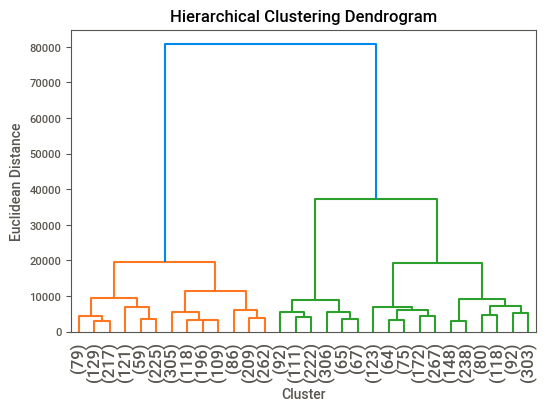

In [48]:

import matplotlib.pyplot as plt
dendrogram(X, truncate_mode='lastp')
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel('Euclidean Distance')
plt.xlabel('Cluster')
plt.title('Hierarchical Clustering Dendrogram')


In [49]:
# Looks like 5 clusteres best describe our data based on above dendrogram. So, we get us a model with 5 clusters and store the label in the data frame
from sklearn.cluster import AgglomerativeClustering
agc_model = AgglomerativeClustering(n_clusters = 5)
agc_model.fit(final_encoded_scaled_df)
final_encoded_scaled__clustered_df = copy.deepcopy(final_encoded_scaled_df)
final_encoded_scaled__clustered_df['agglomerative_cluster'] = agc_model.labels_

In [50]:
final_encoded_scaled__clustered_df.head()

Servings  weighted_mean_ratings  calories  protein  carbohydrates  fat  \
0        30                    403       163       46            179   86   
1        23                      8        62       25            109   15   
2        31                      5        43       14             26   38   
3        13                     60       270       78            329  124   
4        28                    436       116       41            173   42   

   sodium  carbohydrates_level  protien_level  fat_level  sodium_level  \
0    1955                    1              2          0             0   
1    1503                    2              2          1             0   
2     250                    1              2          0             1   
3    2841                    2              2          0             0   
4    1315                    2              2          2             2   

   overall_food_quality  tot_labour_cost($)  agglomerative_cluster  
0                     2                  48                      4  
1                     1                  62                      3  
2                     1                 177                      1  
3                     2                  58                      2  
4                     1                  34                      3

  we could try to see several of the ffeatures, but there are too many combinations even if we want to see a 5D scatter plots </br>
  ```python
  from itertools import combinations
  comb = list(combinations(list(final_encoded_scaled__clustered_df.index), 3))
  len(comb) 
  ```

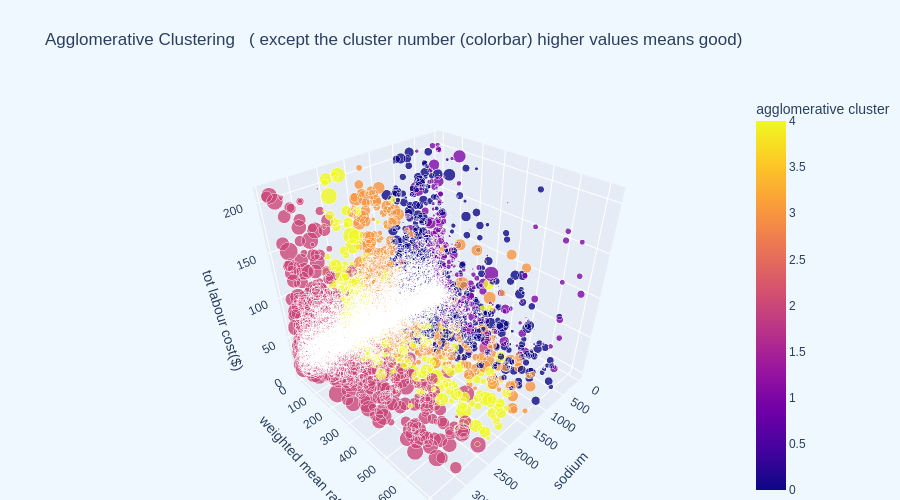

In [51]:
# will do just one plot here 
import plotly.offline
plotly.offline.init_notebook_mode()

import plotly.express as px
fig1 = px.scatter_3d(final_encoded_scaled__clustered_df, 
x = 'sodium',
y='weighted_mean_ratings',
z='tot_labour_cost($)',
color='agglomerative_cluster', 
opacity = 0.8, 
size='fat',
 size_max=30,
 labels={col:col.replace('_', ' ') for col in final_encoded_scaled__clustered_df.columns}
 )


fig1.update_layout(width=900, height=500,
paper_bgcolor = 'aliceblue',
title =f'Agglomerative Clustering \n\n( except the cluster number (colorbar) higher values means good)',
margin = dict(l=0,r=0,b=0,t=90 ),
coloraxis_colorbar_x=.85
        )
# Uncomment fig1.show() below for interactive image. Github does not render plotly plots
#fig1.show()
Image(pio.to_image(fig1, format='png'))


A lot to unpack from the Agglomerative Clustering result above. For a star we can say the following

- CLUSTER 0: Low sodium, low fat recipes appear relatively labour inexpensive ( more precisely less time consuming to make)
- CLUSTER 1: There are not many recipes here. Most of them are on the expensive side, and have lower fat, and very low sodium.
- CLUSTER 2: Sit right in the middle of the sodium per serving pack. It appears the less expensive recipes have slightly higer fat than the more expensive ones. The more expensive ones are also poorly rated.
- CLUSTER 3: Amazing. These are fat recipes. Also, too much salt. Total labour cost of making them has a wide range.  So does the wmr
- CLUSTER 4: These recipes have a resemblance to CLUSTER 3 recipes. Some notable differences are... these ones have the second highest sodium, there are really faty ones that are relativel cheap to make and highly rated, probably for that reason.
- Overall, we don't see recipes that take too long to make being rated higher. The opposite is very true. 

In [52]:
# Let us see what KMeans say
from sklearn.cluster import KMeans

elbow = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = "k-means++", max_iter = 500, n_init = 10, random_state = 0)
    kmeans.fit(final_encoded_scaled__clustered_df[['sodium','weighted_mean_ratings','tot_labour_cost($)']])
    elbow.append(kmeans.inertia_)


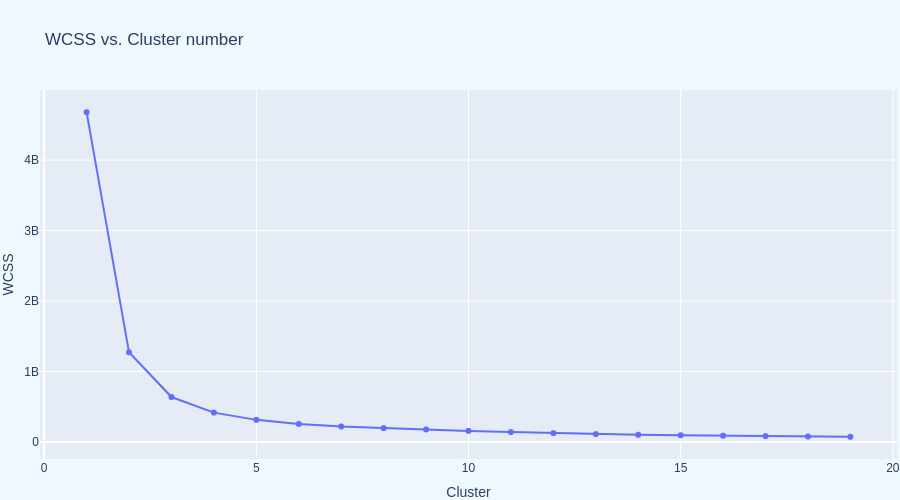

In [53]:

fig2 =  px.line(x=range(1,20), y=elbow, markers=True)

fig2.update_layout(width=900, height=500,
paper_bgcolor = 'aliceblue',
title =f'WCSS vs. Cluster number',
margin = dict(l=0,r=0,b=0,t=90 ),
coloraxis_colorbar_x=.85,
        )
fig2.layout.xaxis.title = 'Cluster'
fig2.layout.yaxis.title = 'WCSS'

# Uncomment fig2.show() below for interactive image. Github does not render plotly plots
#fig2.show()
Image(pio.to_image(fig2, format='png'))

In [54]:
# above fig suggests five clusters would be the most likely. Good to see the two cluster algorithms agree, although 3 clusters is also possible here
kmeans_model = KMeans(n_clusters = 5, init="k-means++", max_iter = 500, n_init = 10, random_state = 42)
kmeans_model.fit_predict(final_encoded_scaled_df)
final_encoded_scaled__clustered_df['kmean_cluster'] = kmeans_model.labels_

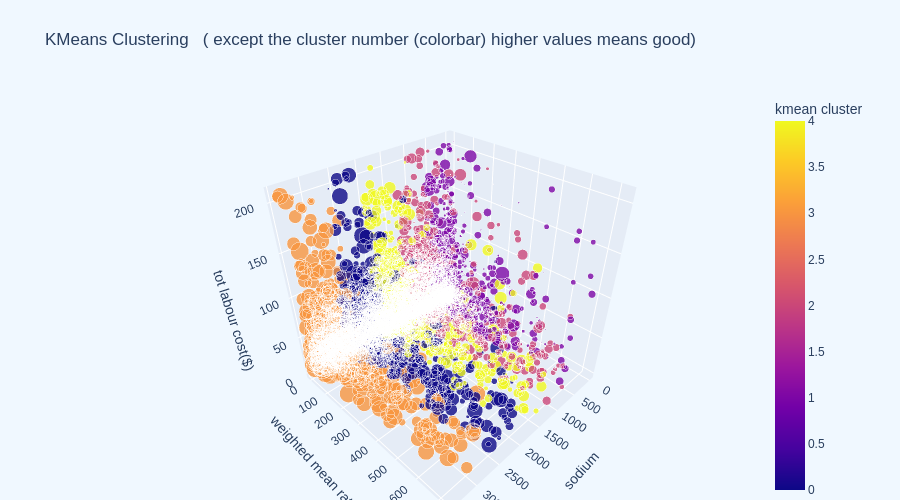

In [55]:
# plot kmeans clusters
fig3 = px.scatter_3d(final_encoded_scaled__clustered_df, 
x = 'sodium',
y='weighted_mean_ratings',
z='tot_labour_cost($)',
color='kmean_cluster', 
opacity = 0.8, 
size='fat',
 size_max=30,
 labels={col:col.replace('_', ' ') for col in final_encoded_scaled__clustered_df.columns}
 )

fig3.update_layout(width=900, height=500,
paper_bgcolor = 'aliceblue',
title =f'KMeans Clustering \n\n( except the cluster number (colorbar) higher values means good)',
margin = dict(l=0,r=0,b=0,t=90 ),
coloraxis_colorbar_x=.85
        )
# Uncomment fig3.show() below for interactive image. Github does not render plotly plots
#fig3.show()
Image(pio.to_image(fig3, format='png'))


A lot to unpack from the KMeans Clustering result above, too.  


- CLUSTER 0: Sit right in the middle of the sodium per serving pack. It appears the less expensive recipes have slightly higer fat. Rating of inexpensive recipes increases with fat levels. Most of the more expensive recipes in this cluster are poorly rated.
- CLUSTER 1: Too much salt and fat here. Total labour cost of making them has a wide range.  So does the wmr.
- CLUSTER 2: Lowest sodium, generally low fat recipes appear relatively labour inexpensive ( more precisely less time consuming to make)
- CLUSTER 3: These recipes have a resemblance to CLUSTER 1 recipes. Some notable differences are... these ones have the second highest sodium, there are really faty ones that are relatively cheap to make and highly rated, probably for that reason. For some reason, the low  fat recipes are cheaper, but less favourably rated.
- CLUSTER 4: There are not many recipes here. Fat levels are almost uniformly low across recipes. Most of them are on the expensive side, and have lower fat, and low sodium.
- Again,  we don't see recipes that take too long to make being rated higher. The opposite is very true. 

In [56]:
# a bit hard to interpret the 3d plots. Reduce dimensions using pca
from sklearn.decomposition import PCA
pca_  = PCA(n_components=2).fit_transform(final_encoded_scaled_df)
kmeans_model_4_pca = KMeans(n_clusters = 5, init="k-means++", max_iter = 500, n_init = 10, random_state = 44)
kmeans_model_4_pca.fit_predict(pca_)
final_encoded_scaled__clustered_df['kmean_cluster_4_pca'] = kmeans_model_4_pca.labels_

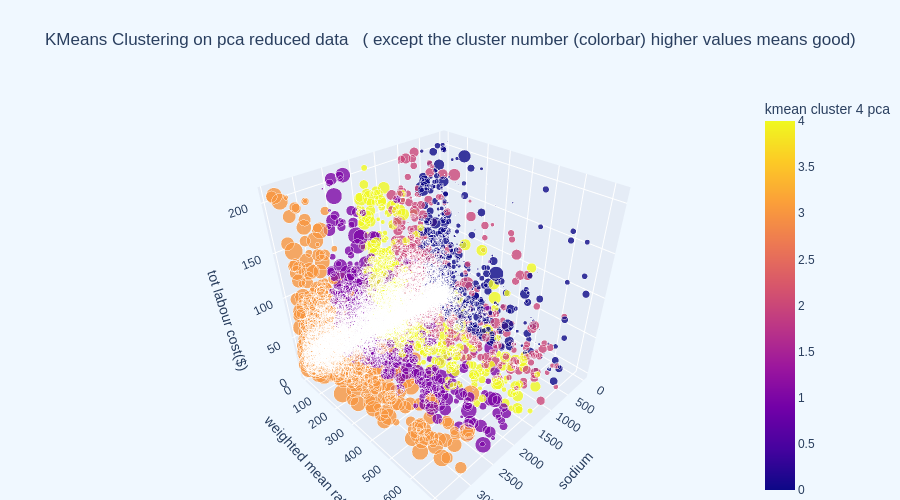

In [57]:

# plot kmeans clusters
fig4 = px.scatter_3d(final_encoded_scaled__clustered_df, 
x = 'sodium',
y='weighted_mean_ratings',
z='tot_labour_cost($)',
color='kmean_cluster_4_pca', 
opacity = 0.8, 
size='fat',
 size_max=30,
 labels={col:col.replace('_', ' ') for col in final_encoded_scaled__clustered_df.columns}
 )

fig4.update_layout(width=900, height=500,
paper_bgcolor = 'aliceblue',
title =f'KMeans Clustering on pca reduced data \n\n( except the cluster number (colorbar) higher values means good)',
margin = dict(l=0,r=0,b=0,t=90 ),
coloraxis_colorbar_x=.85
        )
# Uncomment fig4.show() below for interactive image. Github does not render plotly plots
#fig4.show()
Image(pio.to_image(fig4, format='png'))



In [58]:
# t-SNE 
from sklearn.manifold import TSNE
tsne = TSNE(random_state=30)
tsne_results = tsne.fit_transform(final_encoded_scaled_df) 
tsne_results=pd.DataFrame(tsne_results, columns=['tsne-1', 'tsne-2'])
#Visualize the data
tsne_results['label'] = final_encoded_scaled__clustered_df['agglomerative_cluster']  

In [59]:
tsne_results['agglomerative_cluster'] = final_encoded_scaled__clustered_df['agglomerative_cluster'] 
tsne_results['kmean_cluster'] = final_encoded_scaled__clustered_df['kmean_cluster'] 


In [60]:


# # plot clusters
# fig5 = px.scatter(tsne_results, 
# x = 'tsne-1', 
# y = 'tsne-2',
# color='agglomerative_cluster', 
# opacity = 0.8, 
#  size_max=30,
# #  labels={col:col.replace('_', ' ') for col in final_encoded_scaled__clustered_df.columns}
#  )

# fig5.update_layout(width=900, height=500,
# paper_bgcolor = 'aliceblue',
# title =f'Agglomerative Clustering (t-SNE reduced data)',
# margin = dict(l=0,r=0,b=0,t=90 ),
# # coloraxis_colorbar_x=.85
#         )
# fig5.show()


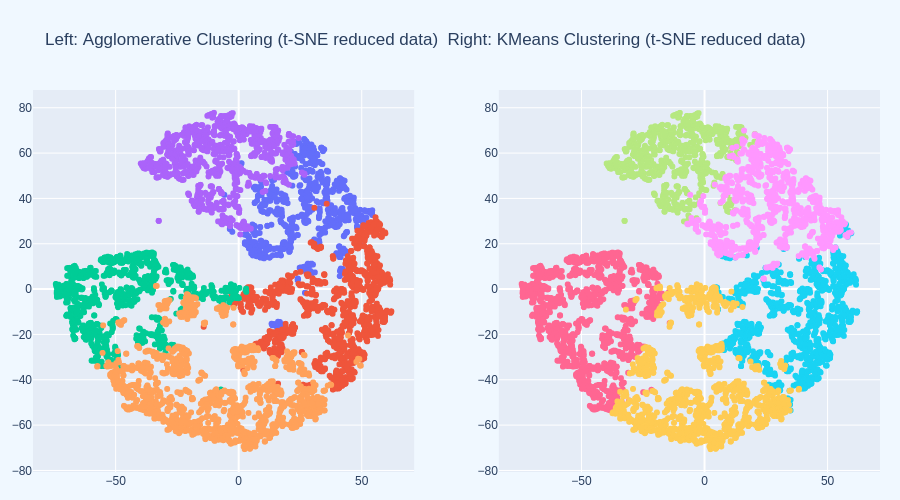

In [61]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig6 = px.line(tsne_results, x="tsne-1", y="tsne-2", color="agglomerative_cluster")
fig7 = px.line(tsne_results, x="tsne-1", y="tsne-2", color="kmean_cluster")


fig8 = make_subplots(rows=1, cols=2)

for d in fig6.data:
    fig8.add_trace((go.Scatter(x=d['x'], y=d['y'], name = d['name'], mode='markers')), row=1, col=1)
        
for d in fig7.data:
    fig8.add_trace((go.Scatter(x=d['x'], y=d['y'],  name = d['name'], mode='markers')), row=1, col=2)
    

fig8.update_layout(width=900, height=500, 
showlegend = False,
paper_bgcolor = 'aliceblue',
title =f'Left: Agglomerative Clustering (t-SNE reduced data)  Right: KMeans Clustering (t-SNE reduced data)',
margin = dict(l=20,r=20,b=20,t=90 ),
        )
# Uncomment fig8.show() below for interactive image. Github does not render plotly plots
#fig8.show()
Image(pio.to_image(fig8, format='png'))


In [63]:

%reset
 

In [64]:
%whos

Interactive namespace is empty.
